# SBS as connectivity Kernel: From Continuous to Categorical Dimensions

This notebook employs a technique to extract "categorical" parameters from continuous Blau dimensions, which can be queried from social surveys. (Refer to Section 1.3.2)

First, we write a function to generate synthetic data of $n$ people in a single continuous dimensional Blau space $X$. For now, we work with a uniformly or exponentially distributed Blau dimension. People's friendships follow an "exponential" kernel, similar to the Logisitic kernel, but this time in the space $Y$, where $y=F_X(x)$ and $F_X(x)$ is the cumulative distribution function of the population in $X$. So we can write:

$P(a_{ij}=1|x_i, x_j) \propto \exp(\theta|F_X(x_i)-F_X(x_j)|)$

This means to generate our data, we can simply generate data in $Y\sim U(0,1)$, and then form $X$ using $x=F_X^{-1}(y)$. 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_data(n=1000, theta=0, phi=0, rate=None):
    import numpy as np
    x = np.random.random(n)
    x.sort()
    def probs(x):
        p = list()
        for i in x:
            p.append(np.exp(theta*np.abs(x-i) + phi))
        p = np.vstack(p)
        np.fill_diagonal(p, 0)
        return p
    p = probs(x)
    net = np.triu(np.random.binomial(1, p))
    net = np.array(net+np.transpose(net), dtype=bool)
    print('mean degree:', np.mean(np.sum(net, axis=1)))
    if rate is not None:
        x = (-1.0/rate)*np.log(1-x)
        dist = sns.kdeplot(x, shade=True)
    return {'x':x, 'p':p, 'net':net, 'theta':theta, 'phi':phi, 'rate':rate}

Since we have derived "exact" expressions for estimating parameters when $X$ is uniform (see equation 24), let us first test with it. We generate a homophilous kernel with large negative $\theta=-10$, and a heterophilous kernel with small positive $\theta=2$, which are likely scenarios for actual social dimensions (especially age). We control $\phi$ such that the mean degree of nodes is consistent across datasets.

In [3]:
y_ho_uni = generate_data(theta=-10, phi=-2.5)

mean degree: 14.742


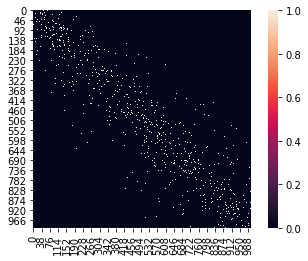

In [4]:
plot = sns.heatmap(y_ho_uni['net'], square=True)

Since we have ordered the nodes by their location in the Blau space, the homophily is immediately apparent on visualizing the adjacency matrix.

In [5]:
y_he_uni = generate_data(theta=2, phi=-5)

mean degree: 14.99


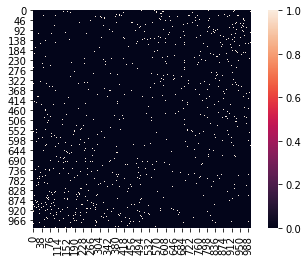

In [6]:
plot = sns.heatmap(y_he_uni['net'], square=True)

Now, a typical social survey might ask queries windowed around the respondent, such as "what proportion of your friends are within 2/5/10 years older or younger to you?" These questions allow the respondent to recall proportions rather simply, instead of asking say "what proportion of your friends are between 10 to 20 years old?" Let's write a function that gives us the mean value of this proportion from the population, corresponding to different windows $w$.

In [7]:
def query_friends(data, w):
    import numpy as np
    if not (isinstance(w, list) or isinstance(w, tuple)): w = [w]
    x = data['x']
    net = data['net']
    n = x.size
    w_prop = np.zeros([len(w), n])
    for i in range(n):
        x_friends = x[net[i]]
        for j in range(len(w)):
            w_prop[j][i] = np.sum(np.abs(x_friends-x[i])<=w[j])/np.size(x_friends)
    return np.mean(w_prop, axis=1)

The above example of age can be continued here. Say age is uniformly distributed between 0 to 100, which leads to corresponding windows of 0.02, 0.05, 0.1, and thus we have:

In [8]:
windows = [0.02, 0.05, 0.1]
y_ho_uni_w = query_friends(y_ho_uni, windows)
y_he_uni_w = query_friends(y_he_uni, windows)

homophily props: [0.20581825 0.43961142 0.6808483 ]
heterophily props: [0.0188237  0.05040363 0.1031003 ]


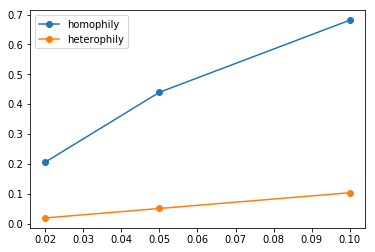

In [9]:
print('homophily props:', y_ho_uni_w)
print('heterophily props:', y_he_uni_w)
plt.plot(windows, y_ho_uni_w, marker='o', label='homophily')
plt.plot(windows, y_he_uni_w, marker='o', label='heterophily')
plt.legend()
plt.show()

The exponential acceleration for homophily is apparent, when compared to heterophily which is almost linear. Now using this as data, we can infer $\theta$.

In [38]:
def infer_theta(data, w=[0.02, 0.05, 0.1]):
    from scipy.optimize import curve_fit
    from numpy import arctan, arctanh, exp, sqrt, array
    
    def f_homophily(w, c): return (2*(exp(c*w)-1)/(c*sqrt(1-exp(c))))*arctanh(sqrt(1-exp(c)))
    def f_heterophily(w, c): return (2*(exp(c*w)-1)/(c*sqrt(exp(c)-1)))*arctan(sqrt(exp(c)-1))
    def f_exponential(w, c): return ((exp(c*w/2)-1)/(3*(exp(c/2)-1)))*((exp(c*w/2)+1)/(exp(c/2)+1)+2)
    
    if data['rate'] is not None:
        from scipy.stats import expon
        lambda_pred = 1.0/expon.fit(data['x'])[1]
        print('actual lambda:', data['rate'])
        print('predicted lambda:', lambda_pred)
    else: lambda_pred = None
        
    p = query_friends(data, w)
    theta_opt = {'+':None, '-':None}
    
    if lambda_pred is None:
        try:
            theta_opt['-'], d = curve_fit(f_homophily, w, p, bounds=(-float('inf'), 0))
        except:
            print ('homophily solution does not exist')
        try:
            theta_opt['+'], d = curve_fit(f_heterophily, w, p, bounds=(0, float('inf')))
        except:
            print ('heterophily solution does not exist')
    else:
        try:
            theta_opt['-'], d = curve_fit(f_exponential, lambda_pred*array(w), p, bounds=(-float('inf'), 0))
        except:
            print('homophily solution does not exist')
        try:
            theta_opt['+'], d = curve_fit(f_exponential, lambda_pred*array(w), p, bounds=(0, float('inf')))
        except:
            print('heterophily solution does not exist')
    return theta_opt

In [20]:
theta_ho_uni = infer_theta(y_ho_uni)
print('inferred:', theta_ho_uni['-'][0], 'original:', y_ho_uni['theta'])

inferred: -9.307032865610205 original: -10


In [21]:
theta_he_uni = infer_theta(y_he_uni)
print('inferred:', theta_he_uni['+'][0], 'original:', y_he_uni['theta'])

inferred: 2.024854951910517 original: 2


We obtain pretty good estimates for our parameters. Now we repeat the analysis for exponentially distributed population $X\sim\mathrm{Exp}(4)$, whle keeping the same kernel parameters.

mean degree: 15.026
mean degree: 14.98


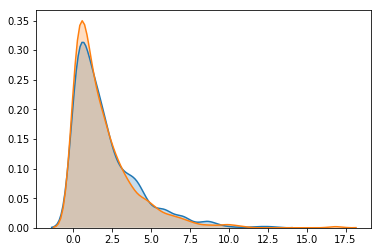

In [55]:
y_ho_exp = generate_data(theta=-10, rate=0.5, phi=-2.5)
y_he_exp = generate_data(theta=2, rate=0.5, phi=-5)

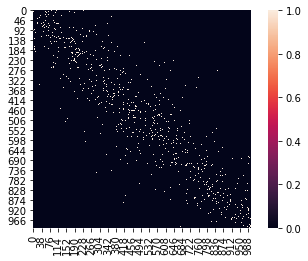

In [56]:
plot = sns.heatmap(y_ho_exp['net'], square=True)

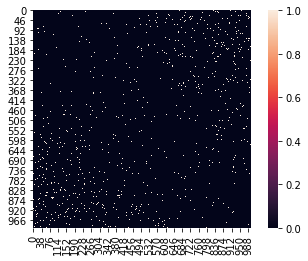

In [57]:
plot = sns.heatmap(y_he_exp['net'], square=True)

Note that the networks look almost identical to what we had earlier, which makes sense because the kernel is applied in $Y$, not $X$.

In [58]:
y_ho_exp_w = query_friends(y_ho_exp, windows)
y_he_exp_w = query_friends(y_he_exp, windows)

exponential props with homophily: [0.0586837  0.12912238 0.23163513]
exponential props with heterophily: [0.00497956 0.01250772 0.02335815]


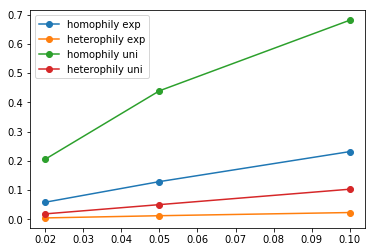

In [59]:
print('exponential props with homophily:', y_ho_exp_w)
plt.plot(windows, y_ho_exp_w, marker='o', label='homophily exp')
print('exponential props with heterophily:', y_he_exp_w)
plt.plot(windows, y_he_exp_w, marker='o', label='heterophily exp')
plt.plot(windows, y_ho_uni_w, marker='o', label='homophily uni')
plt.plot(windows, y_he_uni_w, marker='o', label='heterophily uni')
plt.legend()
plt.show()

Although the windows $w$ remain the same, we obtain a different response to the survey questions, due to the exponential distribution. Let us now infer $\theta$, using the approximate integral definition in equation 25 for small rate parameter $\lambda$.

In [60]:
theta_ho_exp = infer_theta(y_ho_exp)
print('inferred:', theta_ho_exp['-'][0], 'original:', y_ho_exp['theta'])

actual lambda: 0.5
predicted lambda: 0.48509396204067023
inferred: -8.336968387877127 original: -10


In [61]:
theta_he_exp = infer_theta(y_he_exp)
print('inferred:', theta_he_exp['+'][0], 'original:', y_he_exp['theta'])

actual lambda: 0.5
predicted lambda: 0.5217872173506863
inferred: 2.300838451523902 original: 2


We again obtain close estimates to the original. Now, once we have inferred $\theta$, we can finally derive the categorical parameters $\rho_i$, which refers to the proportion of friends of people in community $i$ who are also in community $i$. Eventually, this is the crucial parameter, and $\theta$ is just used to get to it. As noted in the document, for both homophily and heterophly, a large number of communities $\kappa$ will give a "better" estimate of $\rho$. Correspondingly, let's see using equation 29, what these $\rho$s are if we divide the space into equiproportioned communities.

In [62]:
def query_rho(data, k=2, thetas=[]):
    if not isinstance(thetas, list): thetas = [thetas]
    import numpy as np
    k = int(k)
    x = data['x']
    net = data['net']
    communities = np.array_split(x, k)
    fig, ax = plt.subplots()
    for c in communities: plot = sns.distplot(c, kde=False, ax=ax)
    ax2 = ax.twinx()
    memberships = np.hstack([i*np.ones(communities[i].size, dtype=int) for i in range(k)])
    x_axis = [(c[0]+c[-1])/2 for c in communities]
    props = [list() for i in range(k)]
    n = x.size
    for i in range(n):
        m = memberships[i]
        props[m].append(np.sum(memberships[net[i]]==m)/np.sum(net[i]))
    props = [np.mean(p) for p in props]
    plt.plot(x_axis, props, marker='o', label='empirical')
    props_inferred = dict()
    for theta in thetas:
        props_inferred[theta] = list()
        factor = (np.exp(theta/(2*k))-1)*(np.exp(theta/(2*k))+5)/3
        for i in range(1, k+1):
            props_inferred[theta].append(factor/(np.exp(theta*((2*i-1)/(2*k)))+np.exp(theta*(1-(2*i-1)/(2*k)))-2))
        plt.plot(x_axis, props_inferred[theta], marker='o', label='theta '+'%.2f' % round(theta,2))
    plt.legend()
    plt.show()
    return np.sum(props), dict([(key, np.sum(val)) for (key, val) in props_inferred.items()])

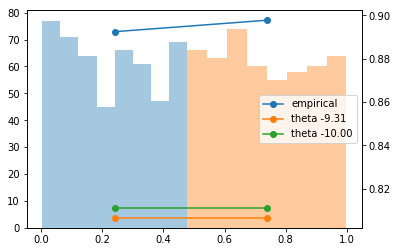

In [64]:
rho_ho_uni_2 = query_rho(y_ho_uni, thetas=[theta_ho_uni['-'][0], y_ho_uni['theta']], k=2)

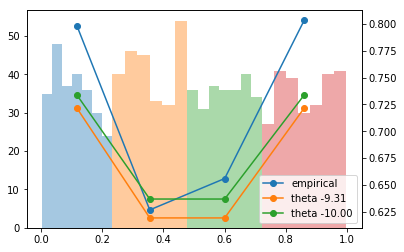

In [65]:
rho_ho_uni_4 = query_rho(y_ho_uni, thetas=[theta_ho_uni['-'][0], y_ho_uni['theta']], k=4)

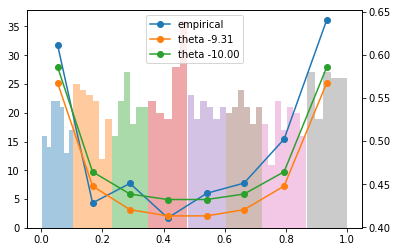

In [67]:
rho_ho_uni_8 = query_rho(y_ho_uni, thetas=[theta_ho_uni['-'][0], y_ho_uni['theta']], k=8)

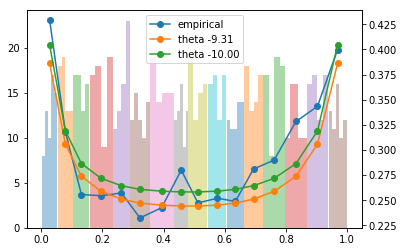

In [68]:
rho_ho_uni_16 = query_rho(y_ho_uni, thetas=[theta_ho_uni['-'][0], y_ho_uni['theta']], k=16)

The inferred parameter gives $\rho$s very close to the empirical estimate. Notice the edge effect, which leads to a U-shaped trend for homophily, and inverse-U-shaped trend for heterophily below.

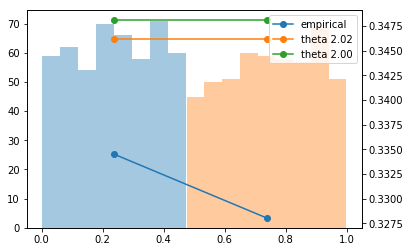

In [69]:
rho_he_uni_2 = query_rho(y_he_uni, thetas=[theta_he_uni['+'][0], y_he_uni['theta']], k=2)

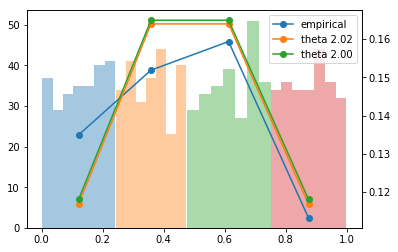

In [70]:
rho_he_uni_4 = query_rho(y_he_uni, thetas=[theta_he_uni['+'][0], y_he_uni['theta']], k=4)

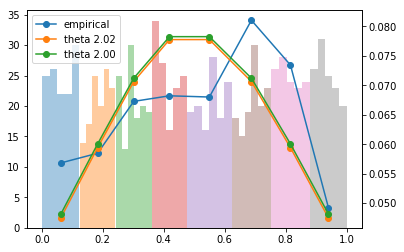

In [71]:
rho_he_uni_8 = query_rho(y_he_uni, thetas=[theta_he_uni['+'][0], y_he_uni['theta']], k=8)

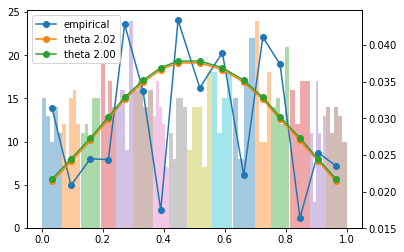

In [72]:
rho_he_uni_16 = query_rho(y_he_uni, thetas=[theta_he_uni['+'][0], y_he_uni['theta']], k=16)

We can do this analysis for exponentially distributed data as well.

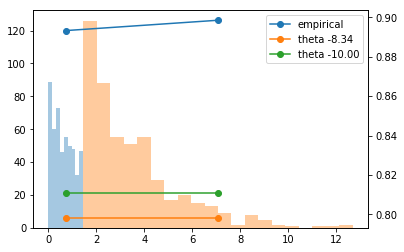

In [73]:
rho_ho_exp_2 = query_rho(y_ho_exp, thetas=[theta_ho_exp['-'][0], y_ho_exp['theta']], k=2)

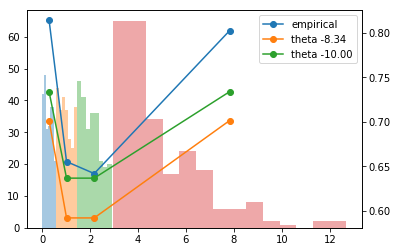

In [74]:
rho_ho_exp_4 = query_rho(y_ho_exp, thetas=[theta_ho_exp['-'][0], y_ho_exp['theta']], k=4)

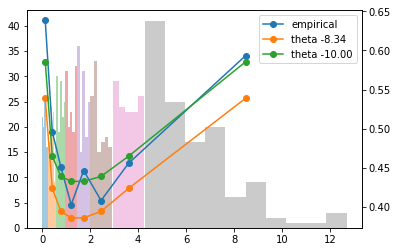

In [75]:
rho_ho_exp_8 = query_rho(y_ho_exp, thetas=[theta_ho_exp['-'][0], y_ho_exp['theta']], k=8)

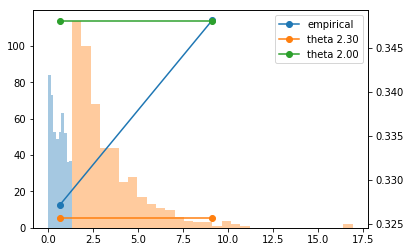

In [76]:
rho_he_exp_2 = query_rho(y_he_exp, thetas=[theta_he_exp['+'][0], y_he_exp['theta']], k=2)

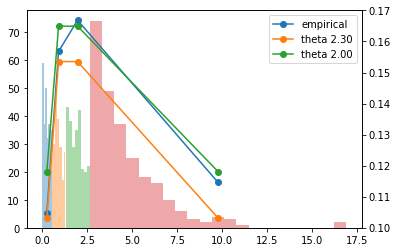

In [77]:
rho_he_exp_4 = query_rho(y_he_exp, thetas=[theta_he_exp['+'][0], y_he_exp['theta']], k=4)

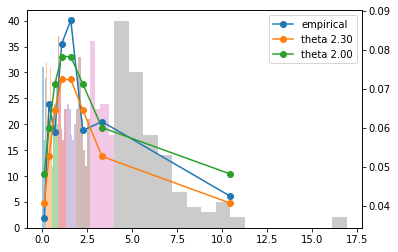

In [78]:
rho_he_exp_8 = query_rho(y_he_exp, thetas=[theta_he_exp['+'][0], y_he_exp['theta']], k=8)